# İçindekiler
* Giriş
* Pandas ile Zaman Serileri Üzerinde Çalışma
    - Zaman serilerini dizinleme ve örnekleme
    - Hisse senedi fiyat serileri için gecikmeler, değişimler ve getiriler
* Temel Zaman Serisi Metrikleri ve Resampling
    - Zaman serilerinin büyüme oranlarını karşılaştırma
    - Zaman serisi frekansını değiştirme: örnekleme
    - .resample() ile yukarı örnekleme ve interpolasyon
    - Aşağı örnekleme ve birleştirme
* Window Fonksiyonları: Kayan ve Genişleyen Metrikler
    - Pandas ile kayan Window fonksiyonları
    - Pandas ile genişleyen Window fonksiyonları
    - Vaka çalışması: S&P500 fiyat simülasyonu
    - Zaman serileri arasındaki ilişkiler: korelasyon

Bu döküman boyunca, zaman serisi verilerini manipüle etmenin temellerini öğreneceksiniz. Zaman serisi verileri, tarih veya saat sıralamasıyla endekslenen verilerdir. Pandas'a yerleşik yöntemleri kullanarak bu indeksle nasıl çalışılacağını öğreneceksiniz. Ayrıca, zaman serilerini örnekleme yaparak frekanslarını nasıl değiştireceğinizi öğreneceksiniz. Bu döküman aynı zamanda zaman serileri için hareketli ve toplam değerleri nasıl hesaplayacağınızı gösterecektir. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


<img src="Resimler/ts2_001.png" alt="" style="width: 400px;"/>

Bir haftalık veri oluşturalım, sonuç üzerinde döngü yapalım ve her bir tarih için dayofweek ve weekday_name'i alalım.


In [4]:
# Tarih aralığını burada oluşturun
# '2017-1-1' tarihinden başlayarak (varsayılan) günlük sıklıkta yedi tarih oluşturmak için pd.date_range'yi kullanın.
# start ve periods argümanlarını kullanın. Sonucu seven_days'e atayın.
seven_days = pd.date_range(start='2023-12-11', periods=7, freq='D')

seven_days

DatetimeIndex(['2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14',
               '2023-12-15', '2023-12-16', '2023-12-17'],
              dtype='datetime64[ns]', freq='D')

In [5]:
# Tarihler üzerinde döngü yapın ve haftanın gününün sayısını ve adını yazdırın
for gun in seven_days:
    print(gun.dayofweek, gun.day_name())

0 Monday
1 Tuesday
2 Wednesday
3 Thursday
4 Friday
5 Saturday
6 Sunday


## Indexing & resampling time series

In [6]:
df = pd.read_csv('Datasets/veri.csv')#, index_col='date')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,date,ozone,pm25,co
0,1999-07-01,0.012024,20.000000,1.300686
1,1999-07-02,0.027699,23.900000,0.958194
2,1999-07-03,0.043969,36.700000,1.194444
3,1999-07-04,0.035161,39.000000,1.081548
4,1999-07-05,0.038359,28.171429,0.939583


In [7]:
data = df
# Verinin keşfedilmesi
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6317 entries, 0 to 6316
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6317 non-null   object 
 1   ozone   6317 non-null   float64
 2   pm25    6317 non-null   float64
 3   co      6317 non-null   float64
dtypes: float64(3), object(1)
memory usage: 197.5+ KB
None


In [8]:
# Tarih verilerini dönüştürme
pd.to_datetime(data.date)
data.head()

,date,ozone,pm25,co
0,1999-07-01,0.012024,20.000000,1.300686
1,1999-07-02,0.027699,23.900000,0.958194
2,1999-07-03,0.043969,36.700000,1.194444
3,1999-07-04,0.035161,39.000000,1.081548
4,1999-07-05,0.038359,28.171429,0.939583


In [9]:
# Verinin Keşfedilmesi
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6317 entries, 0 to 6316
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6317 non-null   object 
 1   ozone   6317 non-null   float64
 2   pm25    6317 non-null   float64
 3   co      6317 non-null   float64
dtypes: float64(3), object(1)
memory usage: 197.5+ KB
None


In [10]:
# Tarih sütununun indis olarak ayarlanması 
data.set_index('date', inplace=True)
# Veriye bakalım
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6317 entries, 1999-07-01 to 2017-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ozone   6317 non-null   float64
 1   pm25    6317 non-null   float64
 2   co      6317 non-null   float64
dtypes: float64(3)
memory usage: 197.4+ KB
None


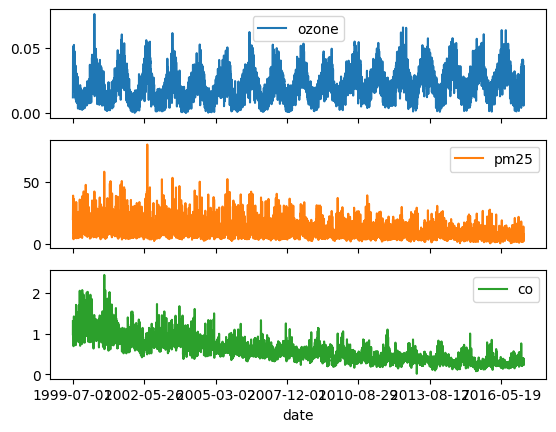

In [11]:
# Veriyi Görselleştirelim
data.plot(subplots=True)
plt.show();

#### Yıllık Hisse Senedi Fiyatı Eğilimlerini Karşılaştırılması

In [12]:
df = pd.read_csv('Datasets/yahoo.csv', parse_dates=True, index_col='date')
#df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,price
date,
2013-01-02,20.08
2013-01-03,19.78
2013-01-04,19.86
2013-01-07,19.40
2013-01-08,19.66


In [13]:
# İlgili yıl verilerini seçerek ve prices ile birleştirerek dataframe oluşturun
prices = pd.DataFrame()

for yil in ['2013', '2014', '2015']:
    yil_bazli_fiyat = df.loc[yil, ['price']].reset_index(drop=True)
    yil_bazli_fiyat.rename(columns={'price': yil}, inplace=True)
    prices = pd.concat([prices, yil_bazli_fiyat], axis=1)

prices.head()

,2013,2014,2015
0,20.08,NaN,NaN
1,19.78,39.59,50.17
2,19.86,40.12,49.13
3,19.40,39.93,49.21
4,19.66,40.92,48.59


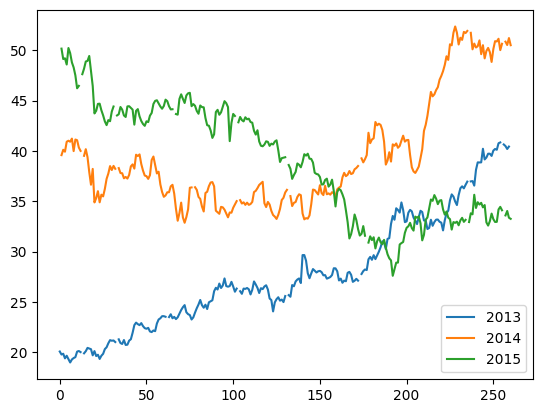

In [15]:
# Verinin Görselleştirilmesi
prices.plot()
plt.show();

# Frekansın Değiştirilmesi 
2005-17 yılları arasındaki NYC, LA ve Chicago'daki günlük karbon monoksit konsantrasyonu verilerini kullanarak,önce frekansı takvim günlük olarak ayarlanacak ve ardından aylık frekansta örnek alınacaktır. İki seriyi görselleştirerek farklı frekansların veriyi nasıl etkilediğini görebiliriz.

In [16]:
df = pd.read_csv('Datasets/co.csv', parse_dates=True, index_col='date')
#df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Chicago,Los Angeles,New York
date,,,
2005-01-01,0.317763,0.777657,0.639830
2005-01-03,0.520833,0.349547,0.969572
2005-01-04,0.477083,0.626630,0.905208
2005-01-05,0.348822,0.613814,0.769176
2005-01-06,0.572917,0.792596,0.815761


In [17]:
co = df
# Veriyi inceleyelim
print(co.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1898 entries, 2005-01-01 to 2010-12-31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Chicago      1898 non-null   float64
 1   Los Angeles  1898 non-null   float64
 2   New York     1898 non-null   float64
dtypes: float64(3)
memory usage: 59.3 KB
None


In [18]:
# Verininin frekansını günlük olarak değiştirelim
co = co.asfreq('D')

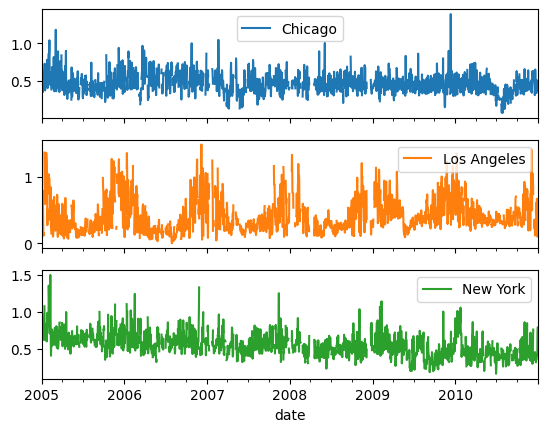

In [19]:
co.plot(subplots=True)
plt.show();

In [20]:
# Frekansı Aylık olarak ayarlayalım
co = co.asfreq('M')

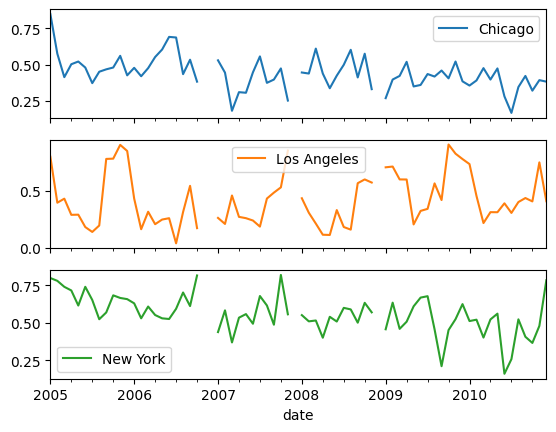

In [21]:
co.plot(subplots=True)
plt.show();

## Gecikmeler, Değişiklikler ve Hisse Senedi Fiyat Serileri İçin Getiriler
### Zaman içinde hisse senedi fiyatlarını kaydırmak
Değerleri geçmişe veya geleceğe kaydırmak veya geciktirmek için shift(): Veriyi geçmiş ve gelecek arasında taşımak. Varsayılan olarak bir dönemi geleceğe kaydırır, ancak istediğiniz kaydırma değerini periods değişkenine vererek değiştirebilirsiniz.

Şimdi, Google için bir hisse senedi fiyat serisini hem geçmişe hem de geleceğe doğru 90 iş günü kaydırarak görsel olarak karşılaştırmak için bu yöntemi kullanalım.


In [23]:
google = pd.read_csv('Datasets/google.csv', parse_dates=['Date'], index_col='Date')
google.head()

,Close
Date,
2014-01-02,556.00
2014-01-03,551.95
2014-01-04,NaN
2014-01-05,NaN
2014-01-06,558.10


In [24]:
# iş günlerine göre frekansın ayarlanması
google = google.asfreq('B')

In [25]:
# 'lagged' ve 'shifted' adlı yeni sütunları oluşturun
# google'a, Close sütununu sırasıyla geçmişe ve geleceğe 90 iş günü kaydıran lagged ve shifted sütunlarını ekleyin.
google['lagged'] = google.Close.shift(periods=-90)
google['shifted'] = google.Close.shift(periods=90)
google.head(10)

,Close,lagged,shifted
Date,,,
2014-01-02,556.00,511.00,NaN
2014-01-03,551.95,518.73,NaN
2014-01-06,558.10,529.92,NaN
2014-01-07,568.86,533.09,NaN
2014-01-08,570.04,526.65,NaN
2014-01-09,564.55,519.98,NaN
2014-01-10,564.52,520.63,NaN
2014-01-13,560.93,528.86,NaN
2014-01-14,574.13,529.77,NaN


In [26]:
google.tail(10)

,Close,lagged,shifted
Date,,,
2016-12-19,794.20,NaN,782.44
2016-12-20,796.42,NaN,777.14
2016-12-21,794.56,NaN,779.91
2016-12-22,791.26,NaN,777.50
2016-12-23,789.91,NaN,775.42
2016-12-26,NaN,NaN,772.15
2016-12-27,791.55,NaN,772.08
2016-12-28,785.05,NaN,769.64
2016-12-29,782.79,NaN,769.41


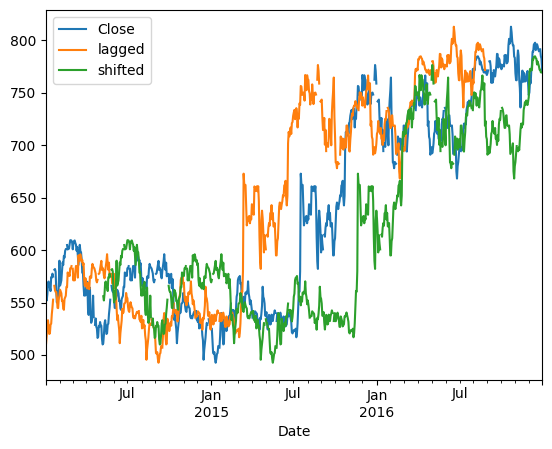

In [27]:
google.plot()
plt.show();


Temel dönüşümler arasında, diziler olarak sağlanan tarihleri ayrıştırma ve sonucu datetime64 olarak adlandırılan eşleşen Pandas veri türüne dönüştürme bulunur. Ayrıca, zaman serinizin alt dönemlerini seçme, DateTimeIndex'in frekansını ayarlama veya değiştirme gibi işlemleri içerir. Frekansı daha yüksek veya daha düşük bir değere değiştirebilirsiniz: yükseltme (upsampling), zaman frekansını artırma anlamına gelir ve bu da yeni veri oluşturmayı gerektirir. Düşük örnekleme (downsampling), zaman frekansını azaltma anlamına gelir ve bu, veriyi bir araya getirmeyi gerektirir.

## Hisse senedi değişimlerini hesapla

Hisse fiyatları verisi ve genel olarak zaman serisi verilerinin önemli özelliklerinden biri yüzde değişimdir. Formülü şu şekildedir: ((X(t)/X(t-1))-1)*100.

Bu yüzde değişimi hesaplamak için df.pct_change() gibi yerleşik bir fonksiyonu kullanabiliriz veya df.div.sub().mul() gibi fonksiyonları kullanabiliriz ve her ikisi de aynı sonuçları verecektir, aşağıdaki örnekte gösterildiği gibi

In [28]:
# Seri ve diğerini bölme işleminin geri dönüşü (binary operator truediv)
# xt / xt-1
google['degisim'] = google.Close.div(google.shifted)

# Seri ve diğerini çıkarma işleminin geri dönüşü (binary operator sub).
# Seri ve diğerini çarpma işleminin geri dönüşü (binary operator mul).
google['getiri'] = google.degisim.sub(1).mul(100)

# Son 10 veriyi göster
google.tail(10)

,Close,lagged,shifted,degisim,getiri
Date,,,,,
2016-12-19,794.20,NaN,782.44,1.015030,1.502991
2016-12-20,796.42,NaN,777.14,1.024809,2.480891
2016-12-21,794.56,NaN,779.91,1.018784,1.878422
2016-12-22,791.26,NaN,777.50,1.017698,1.769775
2016-12-23,789.91,NaN,775.42,1.018687,1.868665
2016-12-26,NaN,NaN,772.15,NaN,NaN
2016-12-27,791.55,NaN,772.08,1.025218,2.521759
2016-12-28,785.05,NaN,769.64,1.020022,2.002235
2016-12-29,782.79,NaN,769.41,1.017390,1.738995


Mevcut ve kaydırılmış fiyatlardan **mutlak değişiklikleri** hesaplayın ve sonucu `.diff()` işleviyle karşılaştırın.

In [29]:
google['diff'] = google.Close.diff() # xt - xt-1
google.tail(10)

,Close,lagged,shifted,degisim,getiri,diff
Date,,,,,,
2016-12-19,794.20,NaN,782.44,1.015030,1.502991,3.40
2016-12-20,796.42,NaN,777.14,1.024809,2.480891,2.22
2016-12-21,794.56,NaN,779.91,1.018784,1.878422,-1.86
2016-12-22,791.26,NaN,777.50,1.017698,1.769775,-3.30
2016-12-23,789.91,NaN,775.42,1.018687,1.868665,-1.35
2016-12-26,NaN,NaN,772.15,NaN,NaN,NaN
2016-12-27,791.55,NaN,772.08,1.025218,2.521759,NaN
2016-12-28,785.05,NaN,769.64,1.020022,2.002235,-6.50
2016-12-29,782.79,NaN,769.41,1.017390,1.738995,-2.26


Bu kod, bir hisse senedi veri çerçevesinde 'Close' sütunundaki fiyatların yüzde değişimini hesaplamaktadır. 'değişim' sütunu, 'Close' sütunundaki bir günün kapanış fiyatını bir önceki günün kapanış fiyatına bölerek hesaplanır. 'getiri' sütunu ise 'değişim' sütunundan 1 çıkarılarak, çıkan sonucu 100 ile çarparak hesaplanır. Bu, yüzde değişimi formülünü uygulayan yaygın bir finansal hesaplama yöntemidir.

## Çoklu dönem getirilerini çizme

Farklı takvim günü periyotları için getirileri hesaplamak için `.pct_change()` fonksiyonunu kullanalım ve sonuçları karşılaştırmak için çizim yapalım. 2014-2016 yılları arasındaki Google hisse senedi fiyatlarını kullanacağız.

`günlük_getiri`, `aylık_getiri` ve `yıllık_getiri` adında sütunlar oluşturalım. Bu sütunlar, sırasıyla 1, 30 ve 360 takvim günü için 'Close' sütununun `.pct_change()` fonksiyonuyla hesaplanan getirileri içersin ve her birini 100 ile çarpalım.

In [33]:
google['günlük_getiri'] = google.Close.pct_change(1,fill_method=None).mul(100)

# Aylık getiriyi oluşturun
google['aylık_getiri'] = google.Close.pct_change(30,fill_method=None).mul(100)

# Yıllık getiriyi oluşturun
google['yıllık_getiri'] = google.Close.pct_change(360,fill_method=None).mul(100)

google.tail()

,Close,lagged,shifted,degisim,getiri,diff,günlük_getiri,aylık_getiri,yıllık_getiri
Date,,,,,,,,,
2016-12-26,NaN,NaN,772.15,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-27,791.55,NaN,772.08,1.025218,2.521759,NaN,NaN,4.358660,19.790248
2016-12-28,785.05,NaN,769.64,1.020022,2.002235,-6.50,-0.821174,2.690718,19.026321
2016-12-29,782.79,NaN,769.41,1.017390,1.738995,-2.26,-0.287880,1.498904,19.245944
2016-12-30,771.82,NaN,769.54,1.002963,0.296281,-10.97,-1.401398,1.483157,17.454955


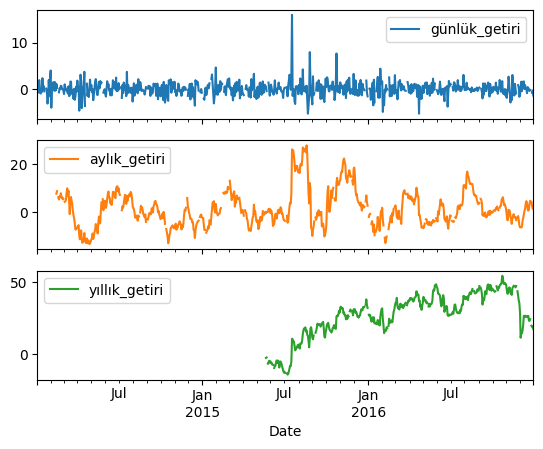

In [34]:
google[['günlük_getiri', 'aylık_getiri', 'yıllık_getiri']].plot(subplots=True)
plt.show();

## Metrikler ve Resampling
Bu bölümde, pandas DateTimeIndex aracılığıyla sunulan temel zaman serisi işlevselliğine daha detaylı bir bakış atacağız. Yeniden örnekleme konseptini tanıtacak ve farklı zaman serilerini başlangıç noktalarını normalize ederek nasıl karşılaştıracağımızı öğreneceğiz."

### Resampling
Zaman serisi verisinin frekansını değiştiren yeniden örnekleme işlemiyle başlayacağız. Bu işlem, genellikle iki zaman serisini birlikte analiz etmek için bunları ortak bir frekansa dönüştürmeniz gerektiğinden oldukça yaygın bir uygulamadır. Veriyi daha yüksek bir frekansa dönüştürerek (upsample) örnekleme yaptığınızda, yeni satırlar oluşturursunuz ve pandas'a bu satırlardaki eksik değerleri nasıl doldurmanız veya interpolasyon yapmanız gerektiğini belirtmeniz gerekir. Veriyi daha düşük bir frekansa dönüştürdüğünüzde (downsample), satır sayısını azaltırsınız ve mevcut verileri nasıl toplamamanız gerektiğini pandas'a belirtmeniz gerekir.


In [35]:
# Veriyi burada içe aktar
# 'asset_classes.csv' dosyasını içe aktarın, .read_csv() kullanarak 'DATE' sütunundaki tarihleri ayrıştırın
# ve bu sütunu endeks olarak ayarlayın, ardından sonucu 'prices' değişkenine atayın.
prices = pd.read_csv('Datasets/asset_classes.csv', parse_dates=['DATE'], index_col='DATE')
prices.head()

,SP500,Bonds,Gold,Oil
DATE,,,,
2007-06-29,1503.35,402.15,648.50,70.47
2007-07-02,1519.43,402.96,650.50,71.11
2007-07-03,1524.87,402.02,657.25,71.41
2007-07-05,1525.40,400.15,655.90,71.81
2007-07-06,1530.44,399.31,647.75,72.80


In [36]:
print(prices.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2469 entries, 2007-06-29 to 2017-06-26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   2469 non-null   float64
 1   Bonds   2469 non-null   float64
 2   Gold    2469 non-null   float64
 3   Oil     2469 non-null   float64
dtypes: float64(4)
memory usage: 96.4 KB
None


In [37]:
# İlk fiyatları seç
# .iloc[0] kullanarak her serinin ilk fiyatını seçin ve sonucu 'first_prices' değişkenine atayın.
first_prices = prices.iloc[0]
first_prices

SP500    1503.35
Bonds     402.15
Gold      648.50
Oil        70.47
Name: 2007-06-29 00:00:00, dtype: float64

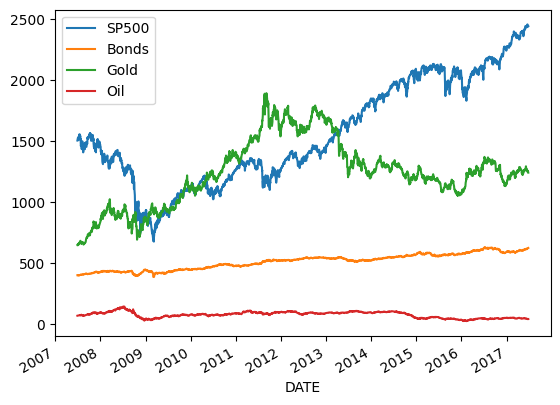

In [38]:
prices.plot()
plt.show();

In [41]:
# Normalleştirilmiş veriyi oluştur
# prices'ı first_prices'a bölün, 100 ile çarpın ve sonucu 'normalized' değişkenine atayın.
normalized = prices.div(first_prices).mul(100)
normalized.head()

,SP500,Bonds,Gold,Oil
DATE,,,,
2007-06-29,100.000000,100.000000,100.000000,100.000000
2007-07-02,101.069611,100.201417,100.308404,100.908188
2007-07-03,101.431470,99.967674,101.349268,101.333901
2007-07-05,101.466724,99.502673,101.141095,101.901518
2007-07-06,101.801976,99.293796,99.884348,103.306372


prices.div(first_prices): Bu ifade, 'prices' DataFrame'ini 'first_prices' DataFrame'ine böler. Her bir değeri, aynı konumda bulunan 'first_prices' değerine böler.

.mul(100): Bu ifade, bölme işleminin sonucunu 100 ile çarpar. Böylece, veriyi başlangıç noktasına göre normalize etmiş olursunuz.

normalized.head(): Bu ifade, 'normalized' DataFrame'inin ilk beş satırını görüntüler, böylece normalleştirilmiş veriyi inceleyebilirsiniz.


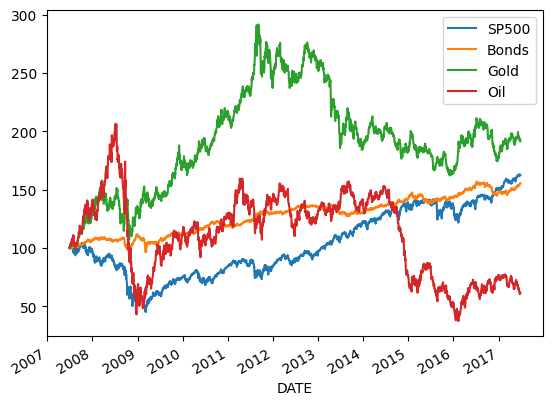

In [42]:
normalized.plot()
plt.show();

## Bir endeks ile hisse senedi fiyatlarını karşılaştırma

Çeşitli hisse senetlerinin performansını bir endeksle karşılaştıralım. NYSE'deki en büyük üç hisse senedini, 30 büyük ABD şirketini içeren Dow Jones Endüstri Ortalaması ile karşılaşarak hisse senetleri piyasası hakkında daha fazla bilgi edinelim.

NYSE'deki en büyük üç şirket şunlardır (Kod yazıldığı zaman):

Şirket (Hisse Kodu):

* Johnson & Johnson (JNJ)
* Exxon Mobil (XOM)
* JP Morgan Chase (JPM)

In [44]:
stocks = pd.read_csv('Datasets/nyse.csv', parse_dates=['date'], index_col='date')
dow_jones = pd.read_csv('Datasets/dow_jones.csv', parse_dates=['date'], index_col='date')

In [45]:
stocks.head()

,JNJ,JPM,XOM
date,,,
2010-01-04,64.68,42.85,69.15
2010-01-05,63.93,43.68,69.42
2010-01-06,64.45,43.92,70.02
2010-01-07,63.99,44.79,69.80
2010-01-08,64.21,44.68,69.52


In [46]:
dow_jones.head()

,DJIA
date,
2010-01-04,10583.96
2010-01-05,10572.02
2010-01-06,10573.68
2010-01-07,10606.86
2010-01-08,10618.19


In [47]:
# Veriyi birleştir ve sonucu incele
# stocks ve dow_jones'ı birleştirmek için pd.concat() fonksiyonunu axis=1 ile kullanın
# ve sonucu 'data' değişkenine atayın. data'nın .info()'sini inceleyin.
data = pd.concat([stocks, dow_jones], axis=1)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   JNJ     1762 non-null   float64
 1   JPM     1762 non-null   float64
 2   XOM     1762 non-null   float64
 3   DJIA    1762 non-null   float64
dtypes: float64(4)
memory usage: 68.8 KB
None


,JNJ,JPM,XOM,DJIA
date,,,,
2010-01-04,64.68,42.85,69.15,10583.96
2010-01-05,63.93,43.68,69.42,10572.02
2010-01-06,64.45,43.92,70.02,10573.68
2010-01-07,63.99,44.79,69.80,10606.86
2010-01-08,64.21,44.68,69.52,10618.19


pd.concat([stocks, dow_jones], axis=1): Bu ifade, 'stocks' ve 'dow_jones' veri çerçevelerini yatay eksende (axis=1) birleştirir. Yani, hisse senedi verilerini Dow Jones Endüstri Ortalaması veri çerçevesine ekler.


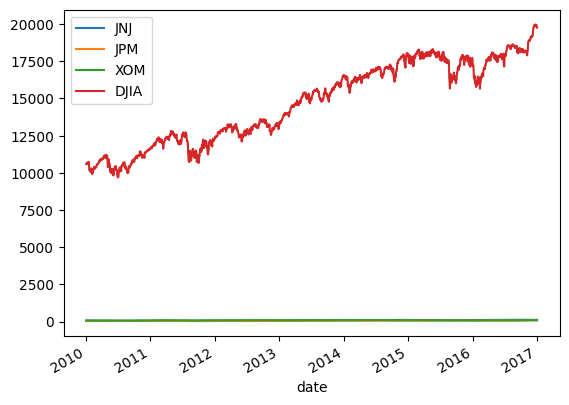

In [48]:
data.plot()
plt.show();

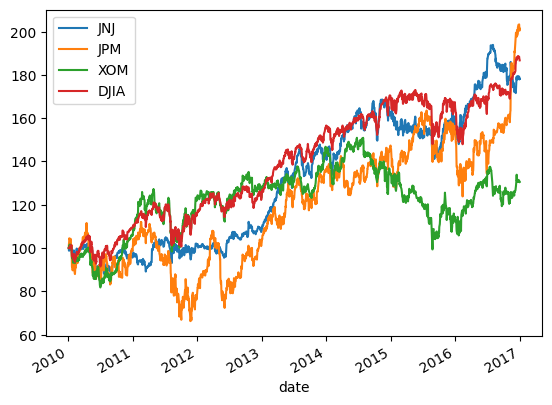

In [49]:
# Normalize edilmiş veririnin eklenmesi
data.div(data.iloc[0]).mul(100).plot()
plt.show();

* Hisse senedinin performans farkını yüzde puanları olarak hesapla ve bir benchmark endeksine göre çizelim. Microsoft (MSFT) ve Apple (AAPL) hisselerinin performansını son 10 yıl boyunca S&P 500 ile karşılaştıralım.

In [50]:
stocks = pd.read_csv('Datasets/msft_aapl.csv', parse_dates=['date'], index_col='date')
stocks.head()

,AAPL,MSFT
date,,
2007-01-03,11.97,29.86
2007-01-04,12.24,29.81
2007-01-05,12.15,29.64
2007-01-08,12.21,29.93
2007-01-09,13.22,29.96


In [51]:
sp500 = pd.read_csv('Datasets/sp500.csv', parse_dates=['date'], index_col='date')
sp500.head()

,SP500
date,
2007-06-29,1503.35
2007-07-02,1519.43
2007-07-03,1524.87
2007-07-05,1525.40
2007-07-06,1530.44


In [52]:
# Hisse senetleri ve endeksleri birleştirin
# pd.concat() kullanarak hisse senetleri ve sp500'ü axis=1 üzerinde birleştirin,
# .dropna() kullanarak eksik değerleri içeren satırları kaldırın ve sonucu 'data' değişkenine atayın.
data = pd.concat([stocks, sp500], axis=1).dropna()
data.head()

,AAPL,MSFT,SP500
date,,,
2007-06-29,17.43,29.47,1503.35
2007-07-02,17.32,29.74,1519.43
2007-07-03,18.17,30.02,1524.87
2007-07-05,18.96,29.99,1525.40
2007-07-06,18.90,29.97,1530.44


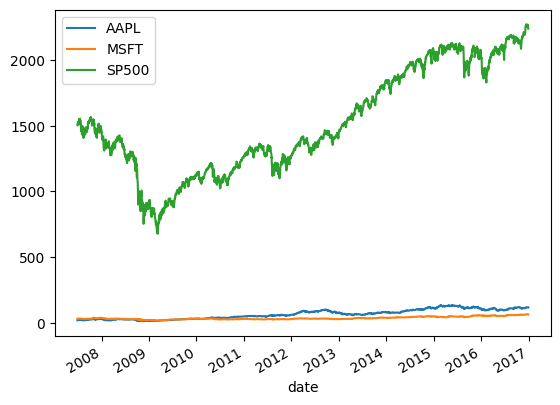

In [53]:
data.plot()
plt.show();

In [54]:
normalized = data.div(data.iloc[0]).mul(100)
normalized.head()

,AAPL,MSFT,SP500
date,,,
2007-06-29,100.000000,100.000000,100.000000
2007-07-02,99.368904,100.916186,101.069611
2007-07-03,104.245554,101.866305,101.431470
2007-07-05,108.777969,101.764506,101.466724
2007-07-06,108.433735,101.696641,101.801976


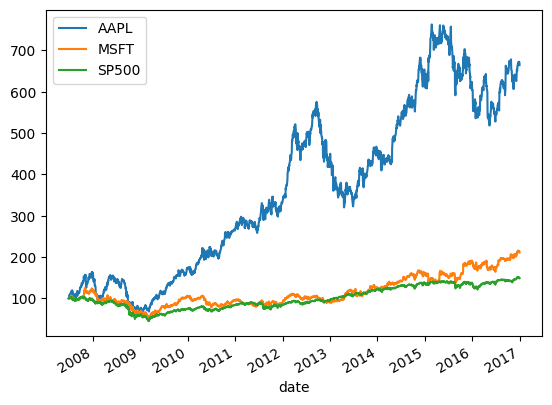

In [55]:
normalized.plot()
plt.show();

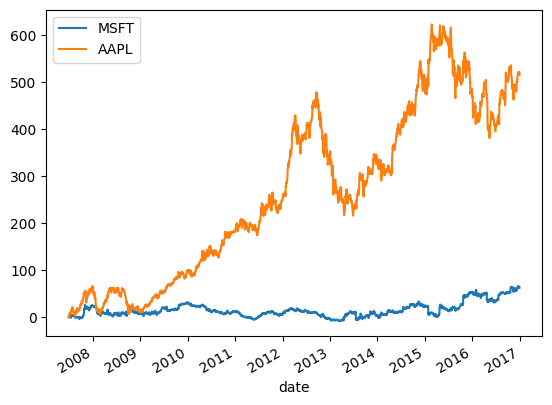

In [56]:
# Ticker'lar oluştur
tickers = ['MSFT', 'AAPL']

# Normalleştirilmiş endeks değerlerini normalleştirilmiş hisse senedi fiyatlarından çıkart ve sonucu çiz
# Ticker'ları normalized'tan seç, normalized['SP500']'den çıkartmak için axis=0 anahtar kelimesini kullan
# ve sonucu çiz.
normalized[tickers].sub(normalized['SP500'], axis=0).plot()
plt.show()

Bu şekilde bu hisse senetlerini genel piyasaya karşı karşılaştırabilir ve trendleri ve aykırı değerleri daha kolay tespit edebilirsiniz


## Aylık verileri haftalık verilere çevirmek

Verinizi yükselttiğinizde neler olduğunu göstermek için, 2016 yılı için nispeten düşük bir üç aylık frekansta, 1–4 arasındaki tamsayı değerleriyle bir Seri oluşturalım. Üç aylık bir frekans seçtiğinizde, pandas dördüncü çeyreğin sonu için varsayılan olarak Aralık ayını kullanır, bu ayı çeyrek takma adıyla değiştirerek farklı bir ay kullanabilirsiniz.


In [63]:
# Başlangıç ve bitiş tarihleri belirleyelim
start = '2023-1-1'
end = '2023-2-28'

In [64]:
# Aylık tarihleri oluşturun
# 'start', 'end' ve frekans takma adı 'M' kullanılarak pd.date_range kullanarak aylık tarihleri oluşturun.
aylik_tarihler = pd.date_range(start=start, end=end, freq='M')
print(aylik_tarihler)

DatetimeIndex(['2023-01-31', '2023-02-28'], dtype='datetime64[ns]', freq='M')


In [65]:
# Aylık oluştur ve yazdır
# data argümanına [1, 2] listesini geçirerek ve monthly_dates'ı indeks olarak kullanarak pd.Series oluşturun ve yazdırın.
aylik = pd.Series(data=[1, 2], index=aylik_tarihler)
print(aylik)

2023-01-31    1
2023-02-28    2
Freq: M, dtype: int64


In [67]:
# Haftalık tarihleri oluşturun
haftalik_tarihler = pd.date_range(start=start, end=end, freq='W')
print(haftalik_tarihler)

DatetimeIndex(['2023-01-01', '2023-01-08', '2023-01-15', '2023-01-22',
               '2023-01-29', '2023-02-05', '2023-02-12', '2023-02-19',
               '2023-02-26'],
              dtype='datetime64[ns]', freq='W-SUN')


In [68]:
# Aylığı yazdır, haftalık_tarihler kullanılarak yeniden indeksle
# .reindex() üç kez uygulayın: önce ek seçeneksiz, 
# ardından ffill ile ve sonra bfill ile, her bir sonucu print() ile yazdırın.
print(aylik.reindex(haftalik_tarihler))

2023-01-01   NaN
2023-01-08   NaN
2023-01-15   NaN
2023-01-22   NaN
2023-01-29   NaN
2023-02-05   NaN
2023-02-12   NaN
2023-02-19   NaN
2023-02-26   NaN
Freq: W-SUN, dtype: float64


In [69]:
print(aylik.reindex(haftalik_tarihler,method='bfill'))

2023-01-01    1
2023-01-08    1
2023-01-15    1
2023-01-22    1
2023-01-29    1
2023-02-05    2
2023-02-12    2
2023-02-19    2
2023-02-26    2
Freq: W-SUN, dtype: int64


In [70]:
print(aylik.reindex(haftalik_tarihler,method='ffill'))

2023-01-01    NaN
2023-01-08    NaN
2023-01-15    NaN
2023-01-22    NaN
2023-01-29    NaN
2023-02-05    1.0
2023-02-12    1.0
2023-02-19    1.0
2023-02-26    1.0
Freq: W-SUN, dtype: float64


## Aylık işsizlik verilerinden haftalık veri oluşturun

ABD işsizlik oranı aylık olarak rapor edilmektedir. Daha sık veriye ihtiyacınız olabilir, ancak bu sorun değil çünkü zaman serisini üst örnekleme (upsample) yöntemini kullanarak nasıl oluşturacağımızı biliyoruz.

Son 20 yıla ait zaman serisi verileri ile çalışacak ve haftalık seriyi çizmeden önce eksik değerleri doldurmak için birkaç seçenek uygulayalım
.

In [71]:
df = pd.read_csv('Datasets/unemployment.csv', parse_dates=['date'], index_col='date')
#df.drop(['Debt/GDP'], axis=1, inplace=True)
df.head()

,UNRATE
date,
2000-01-01,4.0
2000-02-01,4.1
2000-03-01,4.0
2000-04-01,3.8
2000-05-01,4.0


In [75]:
veri = df
# Haftalık serinin ilk beş satırını göster
# data'yı 'W' takma adı ile .asfreq() kullanarak haftalık frekansta dönüştürün 
# ve ilk beş satırı gösterin.
veri.asfreq('W').head()

,UNRATE
date,
2000-01-02,NaN
2000-01-09,NaN
2000-01-16,NaN
2000-01-23,NaN
2000-01-30,NaN


In [76]:
veri.asfreq('W', method='bfill').head()

,UNRATE
date,
2000-01-02,4.1
2000-01-09,4.1
2000-01-16,4.1
2000-01-23,4.1
2000-01-30,4.1


In [77]:
weekly_ffill = veri.asfreq('W', method='ffill')
weekly_ffill.head()

,UNRATE
date,
2000-01-02,4.0
2000-01-09,4.0
2000-01-16,4.0
2000-01-23,4.0
2000-01-30,4.0


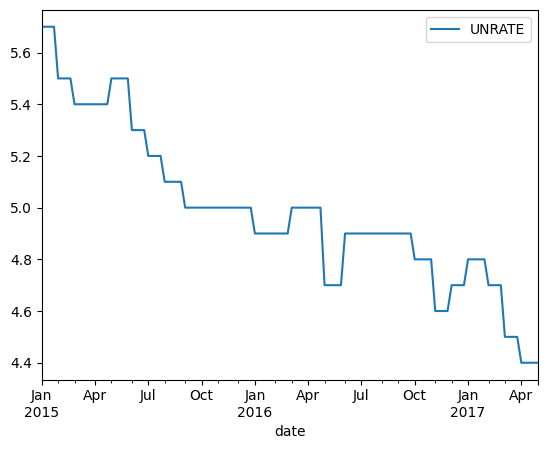

In [78]:
weekly_ffill.loc['2015':].plot()
plt.show();

## İnterpolasyon kullanarak haftalık istihdam verisi oluşturun

Daha önce ABD işsizlik oranını kullanmış ve bunu aylık frekanstan haftalık frekansa basit ileri veya geri doldurma yöntemleriyle dönüştürmüştük. Şimdi önceki yaklaşımınızı yeni .interpolate() yöntemi ile karşılaştıralım.

In [79]:
df = pd.read_csv('Datasets/monthly.csv', parse_dates=['DATE'], index_col='DATE')
#df.drop(['Debt/GDP'], axis=1, inplace=True)
df.head()

,UNRATE
DATE,
2010-01-01,9.8
2010-02-01,9.8
2010-03-01,9.9
2010-04-01,9.9
2010-05-01,9.6


In [81]:
aylik = df
print(aylik.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2010-01-01 to 2017-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UNRATE  85 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB
None


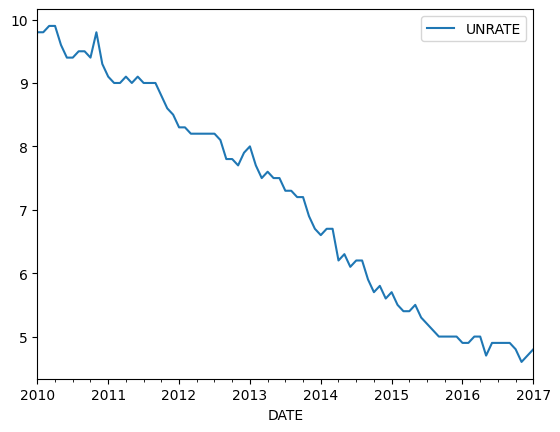

In [82]:
aylik.plot()
plt.show();

In [83]:
# Haftalık tarihleri oluşturun
# Haftalık tarihleri oluşturmak için pd.date_range() kullanın. Başlangıç ve bitiş olarak sırasıyla monthly indeksinin .min() ve .max() değerlerini kullanın.
# Sonucu weekly_dates değişkenine atayın.
haftalik_tarihler = pd.date_range(start=aylik.index.min(), end=aylik.index.max(), freq='W')
haftalik_tarihler

DatetimeIndex(['2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07', '2010-02-14', '2010-02-21',
               '2010-02-28', '2010-03-07',
               ...
               '2016-10-30', '2016-11-06', '2016-11-13', '2016-11-20',
               '2016-11-27', '2016-12-04', '2016-12-11', '2016-12-18',
               '2016-12-25', '2017-01-01'],
              dtype='datetime64[ns]', length=366, freq='W-SUN')

In [84]:
# Aylık veriyi haftalık veriye yeniden indeksle
# Haftalık_dates kullanarak .reindex() fonksiyonunu aylık veri üzerine uygulayın
# ve çıktıyı haftalık değişkenine atayın.
haftalik = aylik.reindex(haftalik_tarihler)
haftalik.tail()

,UNRATE
2016-12-04,NaN
2016-12-11,NaN
2016-12-18,NaN
2016-12-25,NaN
2017-01-01,4.8


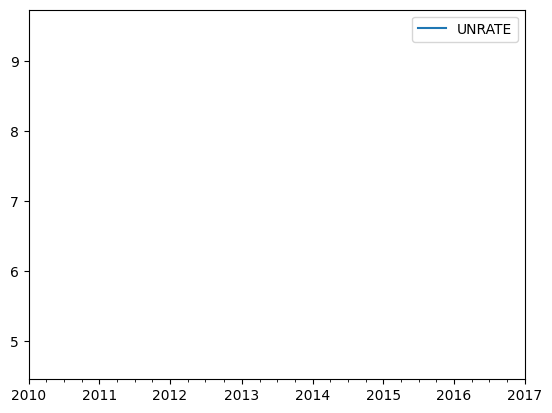

In [85]:
haftalik.plot()
plt.show();

In [86]:
# ffill ve interpolate sütunlarını oluşturun
haftalik['ffill'] = haftalik.UNRATE.ffill()
haftalik['interpolated'] = haftalik.UNRATE.interpolate()

In [87]:
haftalik.tail()

,UNRATE,ffill,interpolated
2016-12-04,NaN,4.7,4.788571
2016-12-11,NaN,4.7,4.791429
2016-12-18,NaN,4.7,4.794286
2016-12-25,NaN,4.7,4.797143
2017-01-01,4.8,4.8,4.800000


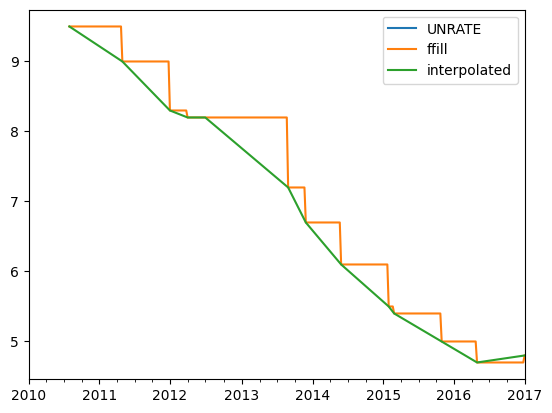

In [89]:
haftalik.plot()
plt.show();

Yeni becerilerinizle zaman serilerini düşük frekansta toplama yeteneğinizi kullanarak, daha yüksek frekansta hisse senedi fiyat serilerini düşük frekansta ekonomik zaman serileri ile karşılaştırabilirsiniz.

İlk örnek olarak, çeyreklik GSYİH büyüme oranını, 30 büyük ABD hissesinin (yeniden örnekleme yapılmış) Dow Jones Endüstri Ortalaması'nın çeyreklik getiri oranıyla karşılaştıralım.

ABD GSYİH büyüme oranları, her çeyreğin başında bir önceki çeyrek için raporlanır. Uyumlu hisse senedi getirilerini hesaplamak için hisse senedi endeksini çeyrek başı frekansına 'QS' takma adını kullanarak yeniden örnekleyecek ve .first() gözlemlerini kullanarak toplayacaksınız.



In [90]:
gdp_growth = pd.read_csv('Datasets/gdp_growth.csv', parse_dates=['date'], index_col='date')
gdp_growth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2007-01-01 to 2017-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gdp_growth  41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes


In [91]:
djia = pd.read_csv('Datasets/djia.csv', parse_dates=['date'], index_col='date')
djia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2007-06-29 to 2017-06-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   djia    2519 non-null   float64
dtypes: float64(1)
memory usage: 40.8 KB


In [92]:
djia_quarterly = djia.resample('QS').first()
djia_quarterly_return = djia_quarterly.pct_change().mul(100)

<Axes: xlabel='date'>

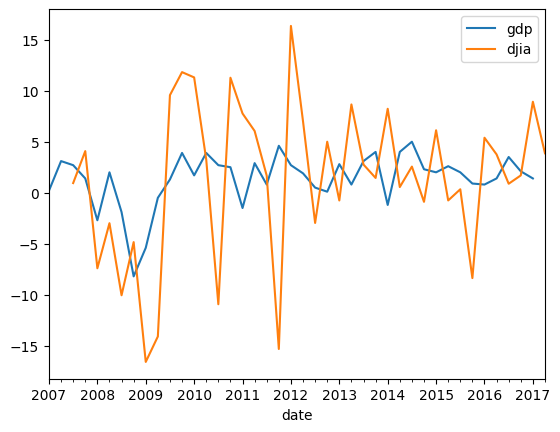

In [93]:
# Birleştir, yeniden adlandır ve djia_quarterly_return ve gdp_growth'ı çiz
# pd.concat() kullanarak gdp_growth ve djia_quarterly_return'ı axis=1 üzerinde birleştir
# ve sonucu 'data' değişkenine atayın. Sütunları .columns kullanarak 'gdp' ve 'djia' olarak yeniden adlandırın,
# ardından .plot() ile sonuçları çizin.
data = pd.concat([gdp_growth, djia_quarterly_return], axis=1)
data.columns = ['gdp', 'djia']
data.plot()

## S&P500 Getiri Oranlarının Aylık Ortalamasını, Medyanını ve Standart Sapmasını Görselleştirme

Ayrıca, `upsampled` veriden birkaç toplu istatistik hesaplamayı da gördük. Şimdi, son 10 yıl boyunca günlük S&P500 getiri oranlarının aylık ortalama, medyan ve standart sapma değerlerinin nasıl değiştiğini keşfetmek için bu bilgiyi kullanalım.


In [94]:
sp500 = pd.read_csv('Datasets/sp500.csv', parse_dates=['date'], index_col='date')
print(sp500.info())
sp500.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2395 entries, 2007-06-29 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   2395 non-null   float64
dtypes: float64(1)
memory usage: 37.4 KB
None


,SP500
date,
2007-06-29,1503.35
2007-07-02,1519.43
2007-07-03,1524.87
2007-07-05,1525.40
2007-07-06,1530.44


In [95]:
# Günlük getirileri burada hesapla
# sp500'ü .squeeze() kullanarak pd.Series()'e çevirin,
# ve günlük getirileri hesaplamak için .pct_change() fonksiyonunu uygulayın.
günlük_getiriler = sp500.squeeze().pct_change()
günlük_getiriler

date
2007-06-29         NaN
2007-07-02    0.010696
2007-07-03    0.003580
2007-07-05    0.000348
2007-07-06    0.003304
                ...   
2016-12-23    0.001252
2016-12-27    0.002248
2016-12-28   -0.008357
2016-12-29   -0.000293
2016-12-30   -0.004637
Name: SP500, Length: 2395, dtype: float64

In [96]:
# Yeniden örnekle ve istatistikleri hesapla
# Günlük getirileri ay sonu frekansına ('M' takma adıyla) .resample() kullanarak örnekle ve 
# 'mean', 'median' ve 'std' hesaplamak için .agg() fonksiyonunu uygula. Sonucu 'stats' değişkenine ata.
stats = günlük_getiriler.resample('M').agg(['mean', 'median', 'std'])
stats

,mean,median,std
date,,,
2007-06-30,NaN,NaN,NaN
2007-07-31,-0.001490,0.000921,0.010908
2007-08-31,0.000668,0.001086,0.015261
2007-09-30,0.001900,0.000202,0.010000
2007-10-31,0.000676,-0.000265,0.008719
...,...,...,...
2016-08-31,-0.000047,-0.000796,0.003562
2016-09-30,-0.000019,-0.000019,0.009146
2016-10-31,-0.000925,-0.001376,0.004160


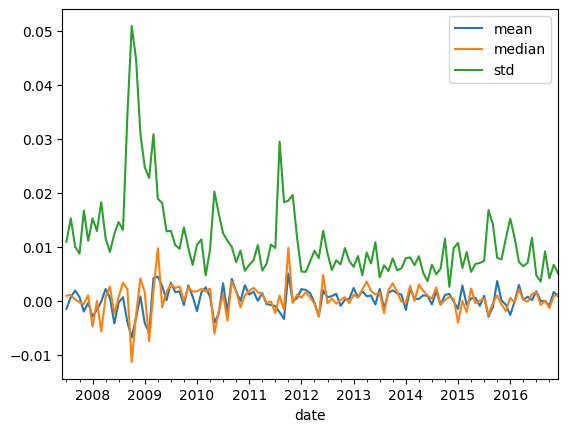

In [97]:
stats.plot()
plt.show();

## Window Functions: Rolling & Expanding Metrics

Window fonksiyonları, zaman serinizin alt dönemlerinde çalışmanıza izin verdiği için faydalıdır. Özellikle, Window fonksiyonları pencere içindeki veriler için metrikler hesaplar. Ardından, bu hesaplamanın sonucu yeni bir zaman serisi oluşturur, burada her bir veri noktası orijinal zaman serisinin birkaç veri noktasının özetini temsil eder. İki ana pencere türünü tartışacağız: Rooling windows aynı boyutta kalırken zaman serisi üzerinde kayarlar, bu nedenle her yeni veri noktası belirli bir gözlem sayısının sonucudur. Expanding windows zaman serisi ile birlikte büyür, bu nedenle yeni bir veri noktasını üreten hesaplama tüm önceki veri noktalarının sonucudur.


## 2010'dan beri New York için hareketli ortalama hava kalitesi

rolling windows fonksiyonları pratiği yapmak için, 2010'dan beri New York City için hava kalitesi eğilimleri ile başlayalım. Özellikle, Çevre Koruma Ajansı tarafından sağlanan günlük Ozon konsantrasyon seviyelerini kullanarak 90 ve 360 günlük hareketli ortalamayı hesaplayalım ve görselleştirelim."

In [98]:
data = pd.read_csv('Datasets/ozone_nyc.csv', parse_dates=['date'], index_col='date')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6291 entries, 2000-01-01 to 2017-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB
None


,Ozone
date,
2000-01-01,0.004032
2000-01-02,0.009486
2000-01-03,0.005580
2000-01-04,0.008717
2000-01-05,0.013754


In [99]:
# 90d ve 360d hareketlerin oralamasını çıkaralım
data['90D'] = data.Ozone.rolling(window='90D').mean()
data['360D'] = data.Ozone.rolling(window='360D').mean()
data.head()

,Ozone,90D,360D
date,,,
2000-01-01,0.004032,0.004032,0.004032
2000-01-02,0.009486,0.006759,0.006759
2000-01-03,0.005580,0.006366,0.006366
2000-01-04,0.008717,0.006954,0.006954
2000-01-05,0.013754,0.008314,0.008314


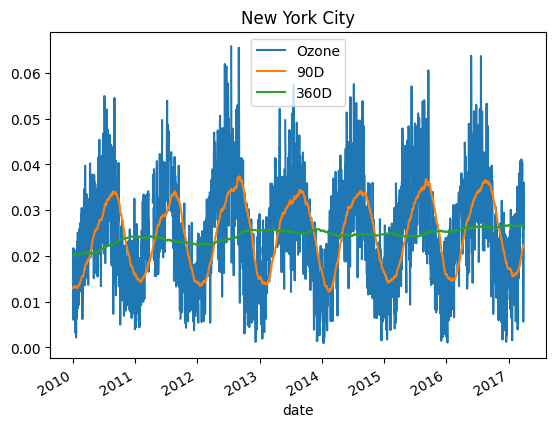

In [100]:
data.loc['2010':].plot()
plt.title('New York City')
plt.show();

Rooling quantiles serinin volatilitesini göstermeye yardımcı olur.


## Expanding window fonksiyonları

###  Kümülatif Toplam vs. .diff()

Expanding windows, kümülatif hesaplamaları çalıştırmanıza olanak tanır.

Aslında, kümülatif toplam yöntemi, daha önce karşılaştığınız .diff() yönteminin tam tersi etkiye sahiptir. Bunun örneklemesi için Google hisse senedi fiyatı zaman serisini kullanalım, fiyatlar arasındaki farkları oluşturalım ve seriyi kümülatif toplam kullanarak yeniden oluşturalım.

In [101]:
df = pd.read_csv('Datasets/google.csv', parse_dates=['Date'], index_col='Date').dropna()
df.head()

,Close
Date,
2014-01-02,556.00
2014-01-03,551.95
2014-01-06,558.10
2014-01-07,568.86
2014-01-08,570.04


In [103]:
differences = df.diff().dropna()
differences.head()

,Close
Date,
2014-01-03,-4.05
2014-01-06,6.15
2014-01-07,10.76
2014-01-08,1.18
2014-01-09,-5.49


In [110]:
baslangic_fiyati = df.first('D')
baslangic_fiyati

/var/folders/vd/hj_vm0156kdg6pg_81flxc600000gn/T/ipykernel_24156/3311623218.py:1: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  baslangic_fiyati = df.first('D')


,Close
Date,
2014-01-02,556.0


In [113]:
cumulative_sum = pd.concat([baslangic_fiyati, pd.DataFrame(differences)], ignore_index=False).cumsum()
cumulative_sum.head()

,Close
Date,
2014-01-02,556.00
2014-01-03,551.95
2014-01-06,558.10
2014-01-07,568.86
2014-01-08,570.04


In [114]:
print(df.equals(cumulative_sum))

True


.cumsum() yöntemi, farklardan orijinal veriyi yeniden oluşturmanıza olanak tanır.

Google ile Apple'a yatırılan $1,000'in kümülatif getirisini karşılaştırmak için yeni kümülatif getiri hesaplama yeteneğinizi pratikte kullanalım. 2010 yılında Google ('GOOG') veya Apple ('AAPL') hisselerine yatırılsaydı, $1,000 ne kadar olurdu?

In [115]:
df = pd.read_csv('Datasets/data_ga.csv', parse_dates=['Date'], index_col='Date')
df.head()

,AAPL,GOOG
Date,,
2010-01-04,NaN,313.06
2010-01-05,NaN,311.68
2010-01-06,NaN,303.83
2010-01-07,NaN,296.75
2010-01-08,NaN,300.71


In [116]:
yatirim = 1000
getiri = df.pct_change()
getiri

,AAPL,GOOG
Date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,-0.004408
2010-01-06,NaN,-0.025186
2010-01-07,NaN,-0.023303
2010-01-08,NaN,0.013345
...,...,...
2017-05-24,-0.002991,0.006471
2017-05-25,0.003456,0.015268
2017-05-26,-0.001690,0.001991


In [119]:
# Kümülatifleri hesapla
getiri_arti_1 = getiri + 1
cumulative_getiri = getiri_arti_1.cumprod()

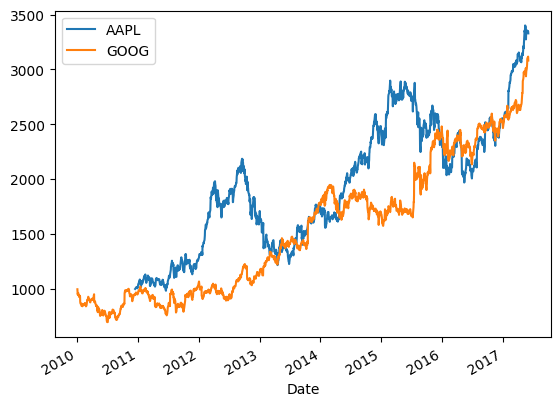

In [120]:
# yatırımı hesapla ve görselleştir
cumulative_getiri.mul(yatirim).plot()
plt.show();

Google ile Apple II'ye yatırılan $1,000 için birikmiş getiri

Apple, tüm dönem boyunca Google'ı geride bıraktı, ancak bu durum çeşitli 1 yıllık alt dönemlerde farklı olabilir, bu nedenle iki hisse senedi arasında geçiş yaparak daha iyi bir sonuç elde etmiş olabilir.

Bu durumu analiz etmek için, 1 yıllık dönemler için birikmiş getiriyi hesaplayalım ve ardından getirileri görmek için görselleştirelim, böylece her bir hissenin ne zaman üstün olduğunu görebiliriz.


In [121]:
import numpy as np
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

In [122]:
df = pd.read_csv('Datasets/data_ga.csv', parse_dates=['Date'], index_col='Date')
df.head()

,AAPL,GOOG
Date,,
2010-01-04,NaN,313.06
2010-01-05,NaN,311.68
2010-01-06,NaN,303.83
2010-01-07,NaN,296.75
2010-01-08,NaN,300.71


In [124]:
getiri_gunluk = df.pct_change()
getiri_gunluk.head()

,AAPL,GOOG
Date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,-0.004408
2010-01-06,NaN,-0.025186
2010-01-07,NaN,-0.023303
2010-01-08,NaN,0.013345


In [125]:
rolling_annual_returns = getiri_gunluk.rolling('360D').apply(multi_period_return)
rolling_annual_returns.tail()

,AAPL,GOOG
Date,,
2017-05-24,0.528052,0.303415
2017-05-25,0.533333,0.323315
2017-05-26,0.538254,0.320434
2017-05-30,0.569342,0.350998
2017-05-31,0.560049,0.335742


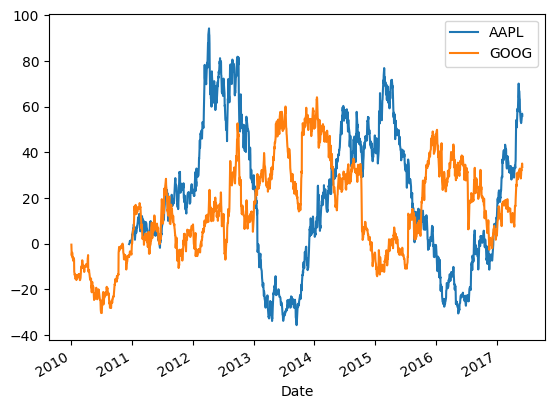

In [126]:
rolling_annual_returns.mul(100).plot()
plt.show();

## Örnek Çalışma :
S&P500 price simulation


Rastgele Yürüyüş (Random Walk) – matematik ve fizik alanında kullanılan bir terim, rastgele bir hareketi ifade eder: zaman içinde, parçacık mevcut konumundan başka bir rastgele seçilen konuma hareket eder. Rastgele yürüyüş, basit bir stokastik süreç örneğidir.

In [127]:
from numpy.random import normal, seed
from scipy.stats import norm

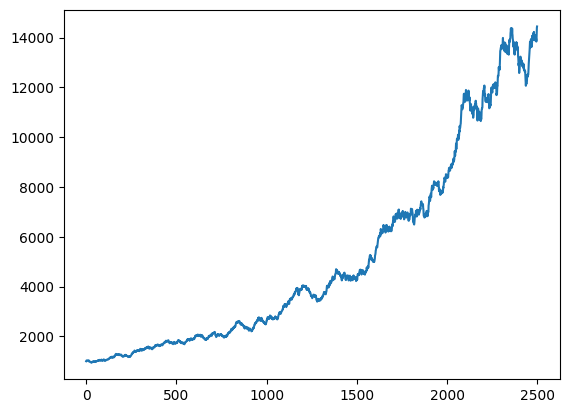

In [128]:
# Seed'i belirle
seed = 42

# Rasgele yürüyüş oluştur
# loc=.001, scale=.01 parametreleri ile normal kullanarak 2,500 rasgele getiri oluşturun 
# ve bunu random_walk değişkenine atayın.
random_walk = normal(loc=.001, scale=0.01, size=2500)

# random_walk'ü pd.Series'e çevir
random_walk = pd.Series(random_walk)

# Rasgele fiyatlar oluştur
# 1'e random_walk'ü ekleyerek ve kümülatif çarpımı hesaplayarak random_prices oluşturun.
random_prices = random_walk.add(1).cumprod()

# random_prices'ı burada çiz
# random_prices'ı 1,000 ile çarparak, 1,000'den başlayan bir fiyat serisi için sonucu çizin.
random_prices.mul(1000).plot()
plt.show();

## ikinci örnek
Facebook'un hisse senedi fiyatının IPO'dan (Halka Arz) başlayarak 31 Mayıs 2017 sonuna kadar olan tarihlerdeki geçmiş getirilerini kullanarak bir rastgele yürüyüş oluşturalım. Ardından, bir sonraki alıştırmada alternatif bir rastgele fiyat yolu simüle edelim.

In [129]:
df = pd.read_csv('Datasets/fb.csv', parse_dates=True, index_col=0, header=None)
df.index.name = 'date'
df.columns = ['price']
df.head()

,price
date,
2012-05-17,38.00
2012-05-18,38.23
2012-05-21,34.03
2012-05-22,31.00
2012-05-23,32.00


In [130]:
fb = df['price']
print(type(fb))
fb

<class 'pandas.core.series.Series'>


date
2012-05-17     38.00
2012-05-18     38.23
2012-05-21     34.03
2012-05-22     31.00
2012-05-23     32.00
               ...  
2017-05-24    150.04
2017-05-25    151.96
2017-05-26    152.13
2017-05-30    152.38
2017-05-31    151.46
Name: price, Length: 1267, dtype: float64

In [131]:
import pandas as pd
from numpy.random import choice, random
import matplotlib.pyplot as plt
import seaborn as sns


seed = 42

In [132]:
# Günlük getiriyi hesaplayalım
gunluk_getiri = fb.pct_change().dropna()
print(gunluk_getiri)

date
2012-05-18    0.006053
2012-05-21   -0.109861
2012-05-22   -0.089039
2012-05-23    0.032258
2012-05-24    0.032188
                ...   
2017-05-24    0.013305
2017-05-25    0.012797
2017-05-26    0.001119
2017-05-30    0.001643
2017-05-31   -0.006038
Name: price, Length: 1266, dtype: float64


In [133]:
n_obs = gunluk_getiri.count()
print(n_obs)

1266


In [134]:
random_walk = choice(gunluk_getiri, size=n_obs)
random_walk

array([ 0.02636186, -0.08520791,  0.04534948, ...,  0.00292873,
       -0.01493609,  0.039254  ])

In [135]:
random_walk = pd.Series(random_walk)

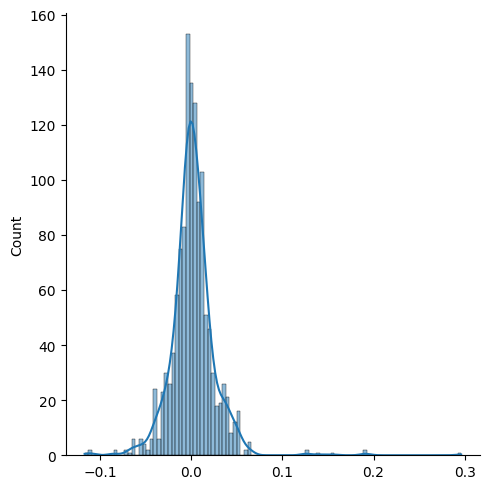

In [138]:
sns.displot(random_walk,kde=True)
plt.show();

## Çeşitli hisse senetleri arasındaki yıllık getiri korelasyonları

Bu alıştırmada, size Apple (AAPL), Amazon (AMZN), IBM (IBM), WalMart (WMT) ve Exxon Mobile (XOM) için Temmuz 2001'den Mayıs 2017'nin sonuna kadar olan son 4.000 işlem günü için tarihsel hisse senedi fiyatlarını sağladık.

Yıl sonu getirilerini hesaplayalım, tüm hisse senetleri arasındaki çiftler arası korelasyonları belirleyelim ve sonucu bir açıklamalı ısı haritası olarak görselleştirelim.


In [139]:
df = pd.read_csv('Datasets/data_corr.csv', parse_dates=True, index_col=0)
df.head()

,AAPL,AMZN,IBM,WMT,XOM
Date,,,,,
2001-07-05,1.66,15.27,NaN,NaN,NaN
2001-07-06,1.57,15.27,106.50,47.34,43.40
2001-07-09,1.62,15.81,104.72,48.25,43.36
2001-07-10,1.51,15.61,101.96,47.50,42.88
2001-07-11,1.61,15.34,103.85,48.85,42.48


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4001 entries, 2001-07-05 to 2017-05-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4000 non-null   float64
 1   AMZN    4000 non-null   float64
 2   IBM     4000 non-null   float64
 3   WMT     4000 non-null   float64
 4   XOM     4000 non-null   float64
dtypes: float64(5)
memory usage: 187.5 KB
None
          AAPL      AMZN       IBM       WMT       XOM
AAPL  1.000000  0.208731  0.460568 -0.183553  0.336413
AMZN  0.208731  1.000000  0.346407 -0.367620 -0.133965
IBM   0.460568  0.346407  1.000000  0.155445  0.367253
WMT  -0.183553 -0.367620  0.155445  1.000000  0.178833
XOM   0.336413 -0.133965  0.367253  0.178833  1.000000


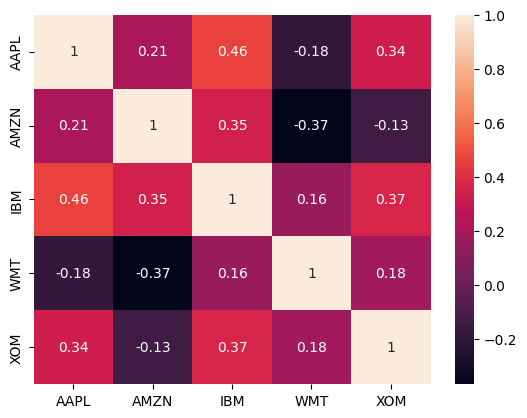

In [140]:
veri = df
# Veriyi incele
print(veri.info())
 
# Yıl sonu fiyatlarını hesapla
yillik_fiyatlar = veri.resample('A').last()
 
# Yıllık getirileri hesapla
yillik_getiriler = yillik_fiyatlar.pct_change()
 
# Korelasyon matrisini hesapla ve yazdır
korelasyonlar = yillik_getiriler.corr()
print(korelasyonlar)
 
# Korelasyonları ısı haritası olarak görselleştir
sns.heatmap(korelasyonlar, annot=True)
plt.show();
